In [5]:
import os
import numpy as np

frames = os.listdir('framesResult')

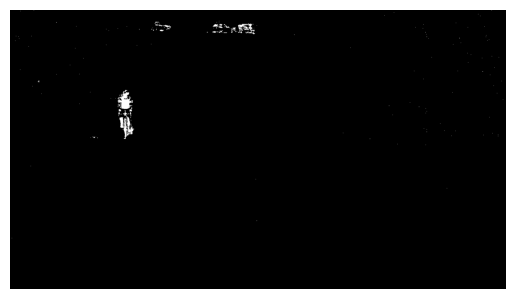

In [6]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

image = cv2.imread('framesResult/' + frames[100], cv2.IMREAD_COLOR)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

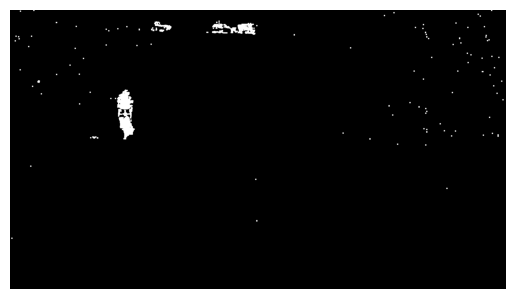

In [7]:
morphed = cv2.morphologyEx(image, cv2.MORPH_ERODE, (1000, 500))
morphed = cv2.morphologyEx(morphed, cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
plt.imshow(morphed, cmap='gray')
plt.axis('off')
plt.show()

8


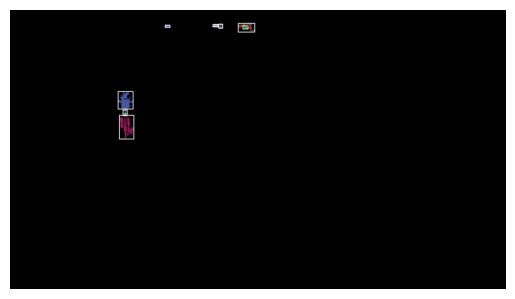

In [9]:
if len(image.shape) > 2:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

output_image = np.zeros_like(image)

min_area_threshold = 100

contador = 0

bounding_boxes = []


for i in range(1, num_labels):  # Exclude background label which is 0
    area = stats[i, cv2.CC_STAT_AREA]
    if area >= min_area_threshold:
        contador += 1
        mask = labels == i
        color = np.random.randint(0, 255, size=3)  # Generate a random color
        output_image[mask] = color

        x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]

        cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 255, 255), 2)


print(contador)

plt.imshow(output_image)
plt.axis('off')
plt.show()